## MCB112  pset11

### Renhao Luo

#### 11/18/2021

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


infile = "w11-data.tbl"

do_init_at_true = False          # An option we can set to initialize centroids to their known/true positions. Useful for debugging.
do_logspace_distance = False     # We'll set this to True when we get to part (3)


### 1. reproduce Watson's K-means results

To reproduce the k-means results, I will use the solutions code from Week5's pset. 

Load the code from week5's pset...

In [2]:
# codes from week5's pset solution
# modified mu so that it incorporates in part 4. 

def sample_component(X):
    """
    Returns a random centroid position
    Input: X[i,g] = the actual data; we use this to determine the min/max in each dimension,
                    and we sample a random vector uniformly on each dimension within those bounds.
    """
    N, G   = np.shape(X)
    dmax   = np.amax(X, axis=0)
    dmin   = np.amin(X, axis=0)
    mu     = np.zeros(G)
    for g in range(G):
        mu[g] = np.random.uniform(dmin[g], dmax[g])
    return mu


In [3]:
def euclidean_dist(v1, v2):
    """
    Return the euclidean distance || v1 - v2 ||.
    If do_logspace_distance is True, do || log(v1) - log(v2) || instead.
    """
    d = 0.
    for i in range(len(v1)):
        if do_logspace_distance:
            d += (np.log(v1[i]) - np.log(v2[i]))**2
        else:
            d += (v1[i] - v2[i])**2
    return np.sqrt(d)

def closest_centroid(x, centroids):
    """
    Input:
       centroids[k,g] : the current centroid positions, for centroids k=0..K-1, dimensions/genes g=0..G-1
       x[g]:            one data point
    Returns best_k, best_dist:
       best_k         : index of the best centroid (0..K-1)
       best_d         : distance to the best centroid
    """
    K, dim = np.shape(centroids)
    best_k = 0
    best_dist = euclidean_dist(x, centroids[0])
    for k in range(1,K):
        dist = euclidean_dist(x, centroids[k])
        if dist < best_dist:
            best_k    = k
            best_dist = dist
    return best_k, best_dist



In [4]:
def assign_kmeans(X, centroids):
    """
    Input:
       X[i,g] are the data point
       centroids[k] are the current centroid positions
    Return assignments, totdist:
       assignments[i] assign each data point i to a cluster k
       tot_sqdist is the total squared distance, the k-means objective function
    """
    K, dim      = np.shape(centroids)
    N           = len(X)
    assignments = np.zeros(N).astype(int)
    tot_sqdist  = 0
    for i,x in enumerate(X):
        assignments[i], di = closest_centroid(x, centroids)
        tot_sqdist += di**2
    return assignments, tot_sqdist

def update_kmeans(X, assignments, K):
    """
    Input:
      X[i,g] are the data points; i=0..N-1,  g=0..G-1
      assignments[i] : which centroid (0..K-1) each point has just been assigned to
      K : how many centroids there are
    Returns:
      centroids[k,g] : updated centroid positions
      pk[k]          : frequency of using component k: how many points were assigned to it, normalized.
    """
    N, G    = np.shape(X)              
    
    centroids = np.zeros((K,G))        
    counts    = np.zeros(K)
    for i in range(N):
        counts[assignments[i]] += 1
        for g in range(G):
            centroids[assignments[i], g] += X[i][g]

    for k in range(K):
        if counts[k] > 0:                                      # In a K-means implementation we have to watch out for the case
            centroids[k] = np.divide(centroids[k], counts[k])  # where a centroid gets no assigned points. Avoid dividing by zero.
        else:                                                  # One strategy is to leave the centroid unchanged. 
            centroids[k] = sample_component(X)                 # Here, instead, we reinitialize it randomly.

    Z = np.sum(counts)
    counts = np.divide(counts, Z)
    return centroids, counts

In [5]:
def diff_assignments(a1, a2):
    """
    Returns the number of assignments that differ between <a1> and <a2>,
    where these are, e.g., a1[i] = 0..K-1, a cluster assignment for each cell i.
    """
    N     = len(a1)
    ndiff = 0
    for i in range(N):
        if a1[i] != a2[i]: 
            ndiff += 1
    return ndiff

def kmeans(X, K, T=np.zeros(0)):
    """
    Input:
       X[i,g]:  data points i=0..N-1, each of which is a vector w/ g=0..G-1
       K     :  how many clusters to fit
       T[i]  :  OPTIONAL: known/true cluster assignments; initialize centroids on their true positions (debugging)
    Return (kp, centroids, assignments, totdist):
       kp[k] :  probability mass (# of data points) assigned to component k
       centroids[k,g] : locations of each cluster centroid
       assignments[i] : which centroid 0..K-1 that each data point i=0..N-1 is assigned to
       tot_sqdist:      total squared Euclidean distance for this k-means solution.
    """
    N, G = np.shape(X)
    
    if len(T) > 0:
        centroids, qp = update_kmeans(X, T, K)
    else:
        centroids = np.zeros((K,G))
        for k in range(K):
            centroids[k] = sample_component(X)
    
    iteration = 0
    while True:
        assignments, tot_sqdist = assign_kmeans(X, centroids)
        if iteration >= 1:
            ndiff = diff_assignments(assignments, old_assignments)
            if ndiff == 0: 
                break
        centroids, kp   = update_kmeans(X, assignments, K)
        old_assignments = assignments
        iteration      += 1
    print("number of runs = {}".format(iteration))

    kp = np.zeros(K)
    for i in range(N):
        kp[assignments[i]] += 1
    kp = np.divide(kp, N)

    return kp, centroids, assignments, tot_sqdist

These are all the functions I need to re-run the Kmeans.
 
Now load the data. 

In [6]:
# load data using pandas
watson_data = pd.read_table(infile, delim_whitespace=True)

# convert the pandas dataframe to numpy matrix
watson_data_np = watson_data.to_numpy()

# convert the data into log space.
watson_data_log = np.log(watson_data_np + 1)

# get the shape of the matrix
N, P        = watson_data.shape
print(N, P)

200 2001


In [7]:
# run the kmeans
# this cell took 10 mins to run
K_cluster    = 8
num_run      = 20
min_sqdist  = float("inf")
best_run     = float("inf")

for r in range(num_run):
    print("Iteration: {}/{}         The current minimum distance is {:5f}".format(r + 1, num_run, min_sqdist))
    np.random.seed(r)
    kp, centroids, assignmnets, total_sqdist = kmeans(watson_data_log, K_cluster)
    if total_sqdist < min_sqdist:
        min_sqdist  = total_sqdist
        best_run    = r

print("The minimum squared distance occured in run {}".format(best_run))


We see the minimum squared distant occurred when run index and seed number are 15, and the minimum distance is 87368.138288, which is very similar to the squared distance as Watsons reported. 

In [8]:
# rerun the best run to get the assignments results.
np.random.seed(15)
kp, centroids, assignmnets, total_sqdist = kmeans(watson_data_log, K_cluster)

number of runs = 10


In [9]:
total_sqdist

87856.94908109047

Reproduce the heatmap that Watson generated. 

In [39]:
# count number of cells assigned to each cluster

unique_cluster, counts = np.unique(assignmnets, return_counts = True)
print(np.asarray((unique_cluster, counts)).T)

# convert the counts into a cumulative counts for separating the cell types. 
cumulative_sum = np.cumsum(counts)

[[ 0 30]
 [ 1 13]
 [ 2  1]
 [ 3  1]
 [ 4 79]
 [ 5 11]
 [ 6 63]
 [ 7  2]]


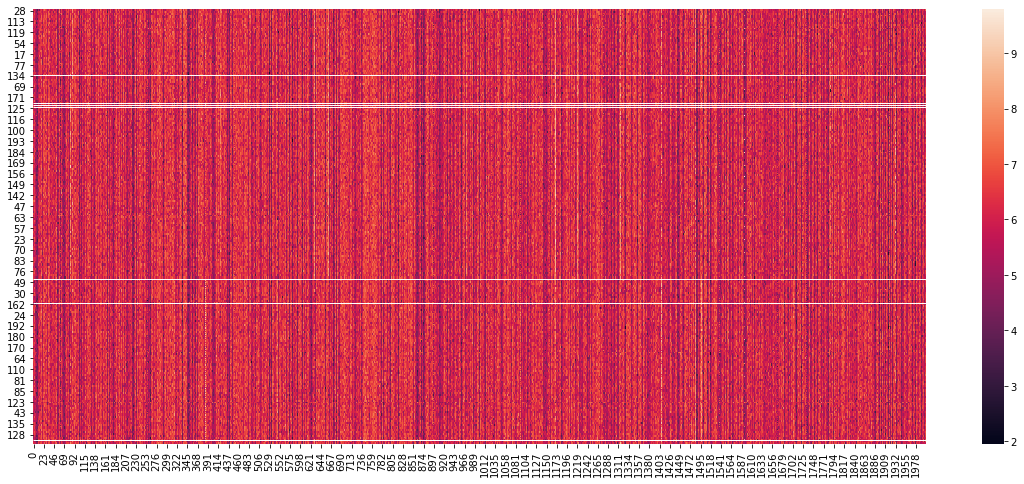

In [11]:
# rearrange the data for the heatmap

watson_data_log_df = pd.DataFrame(watson_data_log)

watson_data_log_df["cluster_assignment"] = assignmnets

watson_data_log_df = watson_data_log_df.sort_values(by = ['cluster_assignment'])

# set axis ticks
x_labels = [i for i in range(0, 2000, 500)]
y_labels = [i for i in range(0, 200, 50)]

# plot heatmap
fig, ax = plt.subplots(figsize = (20, 8))
sns.heatmap(data = watson_data_log_df.loc[:, watson_data_log_df.columns != "cluster_assignment"])

# draw the cluster separation lines to visualize the cluster assignments from the kmeans.
x_min, x_max = plt.xlim()

for counts_idx in range(len(cumulative_sum) - 1):
    ax.hlines(y = cumulative_sum[counts_idx], xmin = x_min, xmax = x_max, color = 'white', lw = 1)



From the heatmap above, we can see that the kmeans successfully re-produced Watson's results. Note: the clusters assignment is totally random, therefore please refer to the number of clusters rather than a specific gene's assignment. 

### 2. reduce the dimensionality



In [12]:
# compute the PCA
def calculate_PCA(data):
    """calculate the PCs using the methods mentioned above

    Args:
        data ([np.array]): [input data in log scale for PCA]
        number_PC ([int]): [select the number of PCs needed to return]

    Returns:
        [np.array]: [return the PCs based on selection]
    """

    X_centered_data = data - np.mean(data, axis = 0)
    U, S, W_t     = np.linalg.svd(X_centered_data)
    W             = W_t.T
    PCs           = np.dot(X_centered_data, W)
    return PCs, U, S, W, W_t

PCs, U, S, W, W_t = calculate_PCA(watson_data_log)

Text(0, 0.5, 'PC2')

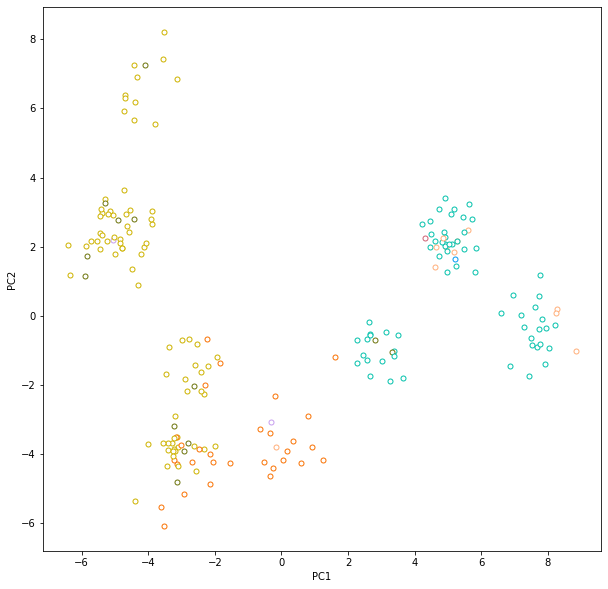

In [13]:
# plot the PC1 and PC2
fig2, ax2 = plt.subplots(figsize = (10, 10))

# We can assign colors to up to Q=10 components. If you want more, add more.
colormap = ['xkcd:orange', 'xkcd:olive', 'xkcd:azure',    'xkcd:rose', 'xkcd:mustard', 
                'xkcd:peach',  'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust', 'xkcd:red']

for i in range(N):
    ax2.plot(PCs[:, :2][i, 0], PCs[:, :2][i, 1], 'o', mec = colormap[assignmnets[i]%8], mfc='w', ms=5)

ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")


#### Calculate eigenvalues



In [14]:
def calculate_eigenvalue(S, N):
    """[calculate the eigenvalue based on SVD]

    Args:
        S ([type]): [description]

    Returns:
        eigen_value ([list]): [A list to store the eigenvalues]
    """
    eigenval = []
    for i in range(N):
        eigenval.append(S[i]**2 / (N-1))

    return eigenval

eigenvalues = calculate_eigenvalue(S, N)

PC value == eigenvector

variance == eigenvalue

Text(0, 0.5, 'Variance Explained')

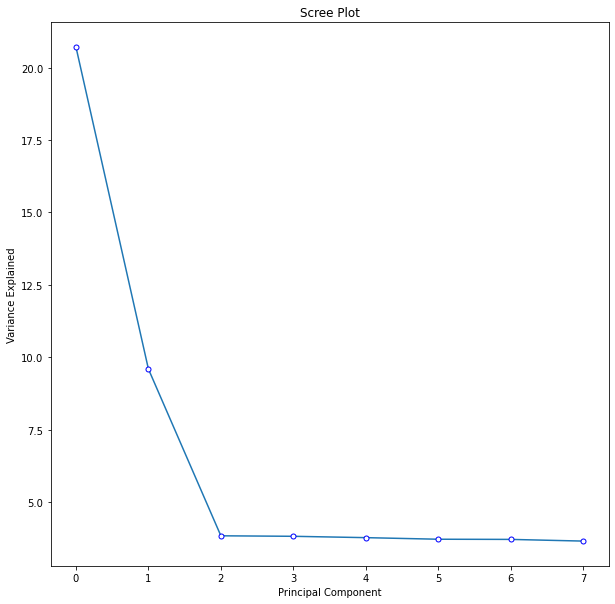

In [29]:
fig3, ax3 = plt.subplots(figsize = (10, 10))
ax3.plot([i for i in range(8)], eigenvalues[:8], 'o-',mec = 'blue',mfc='w', ms=5)

ax3.set_title("Scree Plot")
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Variance Explained')

Text(0, 0.5, 'PC2')

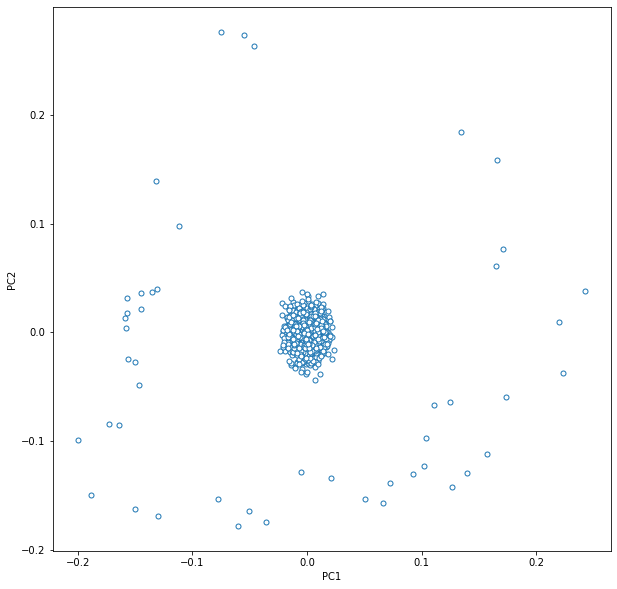

In [34]:

fig4, ax4 = plt.subplots(figsize = (10, 10))
ax4.plot(W[:,:2][:,0], W[:,:2][:,1], 'o', mfc = 'w', ms=5)
ax4.set_xlabel('PC1')
ax4.set_ylabel('PC2')

Text(0, 0.5, 'total variance')

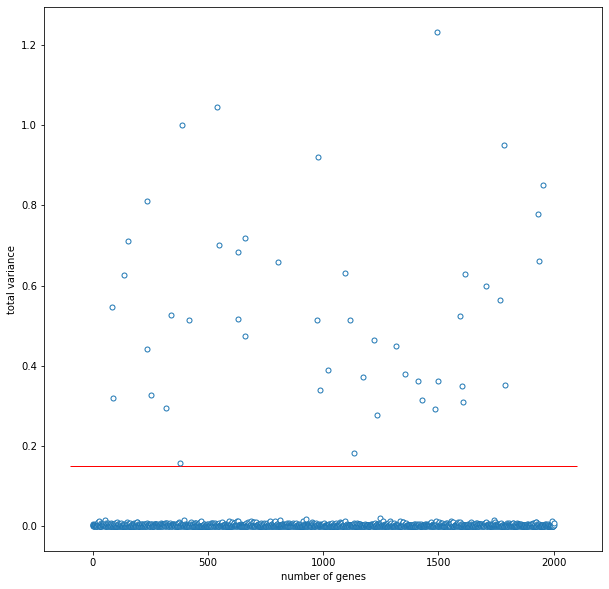

In [35]:

total_variance_PC2 = np.sum(np.dot(np.square(W[:,:2]), np.diag(eigenvalues[0:2])), axis = 1)

fig5, ax5 = plt.subplots(figsize = (10, 10))
ax5.plot(total_variance_PC2, 'o', mfc = 'w', ms=5)
x_min_5, x_max_5 = plt.xlim()
ax5.hlines(y = 0.15, xmin = x_min_5, xmax = x_max_5, color = 'red', lw = 1)
ax5.set_xlabel('number of genes')
ax5.set_ylabel('total variance')


In [18]:
significant_genes = [i for i in total_variance_PC2 if i > 0.15]
print("We have {} genes appear to influence cell type identity. ".format(len(significant_genes)))

We have 47 genes appear to influence cell type identity. 


### 3. check the K

Text(0, 0.5, 'PC2')

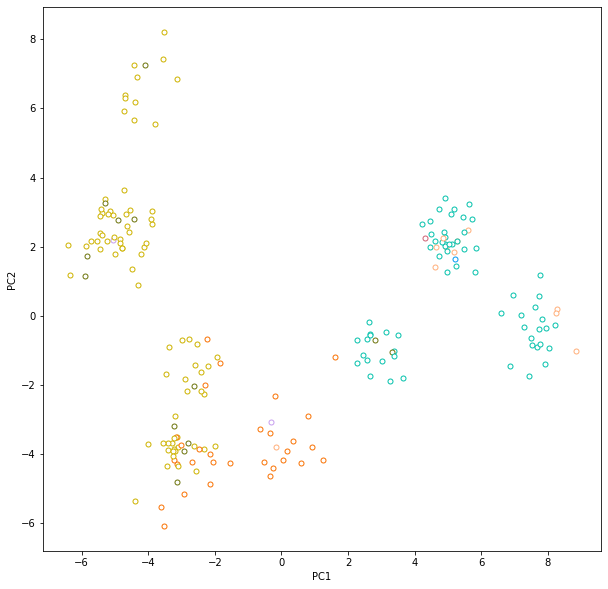

In [19]:
# plot the PC1 and PC2
fig2, ax2 = plt.subplots(figsize = (10, 10))

# We can assign colors to up to Q=10 components. If you want more, add more.
colormap = ['xkcd:orange', 'xkcd:olive', 'xkcd:azure',    'xkcd:rose', 'xkcd:mustard', 
                'xkcd:peach',  'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust', 'xkcd:red']

for i in range(N):
    ax2.plot(PCs[:, :2][i, 0], PCs[:, :2][i, 1], 'o', mec = colormap[assignmnets[i]%8], mfc='w', ms=5)

ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")

K-mean is off.

Redo the kmeans on the PC data to get a better assignment. 

In [20]:
# run the kmeans
# this cell took 10 mins to run
K_cluster    = 8
num_run      = 20
min_sqdist_PCA  = float("inf")
best_run_PCA     = float("inf")

for r in range(num_run):
    print("Iteration: {}/{}         The current minimum distance is {:5f}".format(r + 1, num_run, min_sqdist_PCA))
    np.random.seed(r)
    kp_PCA, centroids_PCA, assignmnets_PCA, total_sqdist_PCA = kmeans(PCs[:, :2], K_cluster)
    if total_sqdist_PCA < min_sqdist_PCA:
        min_sqdist_PCA  = total_sqdist_PCA
        best_run_PCA    = r

print("The minimum squared distance occured in run {}".format(best_run_PCA))


Iteration: 1/20         The current minimum distance is   inf
number of runs = 2
Iteration: 2/20         The current minimum distance is 312.011681
number of runs = 6
Iteration: 3/20         The current minimum distance is 129.709315
number of runs = 4
Iteration: 4/20         The current minimum distance is 129.709315
number of runs = 9
Iteration: 5/20         The current minimum distance is 129.709315
number of runs = 14
Iteration: 6/20         The current minimum distance is 129.709315
number of runs = 2
Iteration: 7/20         The current minimum distance is 129.709315
number of runs = 6
Iteration: 8/20         The current minimum distance is 129.709315
number of runs = 5
Iteration: 9/20         The current minimum distance is 129.709315
number of runs = 5
Iteration: 10/20         The current minimum distance is 129.709315
number of runs = 3
Iteration: 11/20         The current minimum distance is 129.709315
number of runs = 4
Iteration: 12/20         The current minimum distance is

In [21]:
np.random.seed(1)
kp_PCA, centroids_PCA, assignmnets_PCA, total_sqdist_PCA = kmeans(PCs[:, :2], K_cluster)


number of runs = 6


Text(0, 0.5, 'PC2')

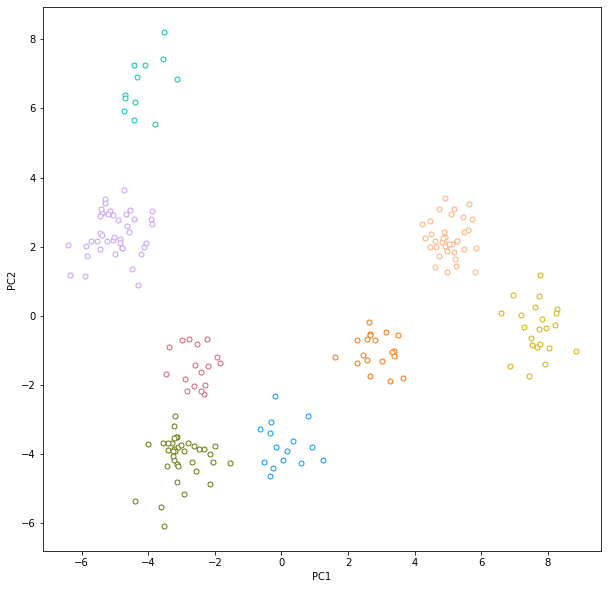

In [22]:
fig6, ax6 = plt.subplots(figsize = (10, 10))

# We can assign colors to up to Q=10 components. If you want more, add more.
colormap = ['xkcd:orange', 'xkcd:olive', 'xkcd:azure',    'xkcd:rose', 'xkcd:mustard', 
                'xkcd:peach',  'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust', 'xkcd:red']

for i in range(N):
    ax6.plot(PCs[:, :2][i, 0], PCs[:, :2][i, 1], 'o', mec = colormap[assignmnets_PCA[i]%8], mfc='w', ms=5)

ax6.set_xlabel("PC1")
ax6.set_ylabel("PC2")

### 4. reconstruct the expression patterns

To reconstruct (de-noise) the data, we will use the following formula:

$$ X^* = U_q S_q W_q^T $$

where q represents the number of PCs we are including, and $U$, $S$, $W^T$ are calculated in the part 2. 

Then to plot the data, we will use the new assignment results from part 3. Here, I will use a heatmap to represent the gene expressions.

In [23]:
new_eigenvectors = U[:, :2] @ np.diag(S[:2]) @ W_t[:2, :]

new_eigenvectors_df = pd.DataFrame(new_eigenvectors)
new_eigenvectors_df["cluster_assignment"] = assignmnets_PCA
new_eigenvectors_df = new_eigenvectors_df.sort_values(by = ['cluster_assignment'])


In [24]:
new_eigenvectors_df

,0,1,2,3,4,5,6,7,8,9,...,1992,1993,1994,1995,1996,1997,1998,1999,2000,cluster_assignment
61,-0.034034,-0.004973,-0.020983,-0.020923,0.005093,-0.003137,-0.016040,-0.019059,-0.028945,0.007967,...,-0.059914,-0.010188,0.009504,-0.004530,-0.019822,-0.014595,0.002772,-0.030497,0.012996,0
180,-0.036094,-0.005405,-0.023875,-0.023869,0.005820,-0.003955,-0.016359,-0.021308,-0.032866,0.007384,...,-0.066187,-0.010726,0.009552,-0.005257,-0.022394,-0.017050,0.003001,-0.034352,0.017177,0
188,-0.048660,-0.006586,-0.023532,-0.023220,0.005611,-0.001984,-0.025536,-0.022880,-0.032734,0.015639,...,-0.075111,-0.014882,0.015691,-0.004667,-0.022869,-0.014600,0.003722,-0.035597,0.005045,0
132,-0.050500,-0.007343,-0.030692,-0.030587,0.007442,-0.004484,-0.023979,-0.027980,-0.042356,0.012113,...,-0.088178,-0.015139,0.014246,-0.006597,-0.029037,-0.021226,0.004097,-0.044704,0.018356,0
25,-0.044745,-0.006132,-0.022578,-0.022324,0.005402,-0.002187,-0.023104,-0.021674,-0.031356,0.013764,...,-0.070600,-0.013639,0.014123,-0.004555,-0.021824,-0.014335,0.003458,-0.033895,0.006604,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.092681,0.013047,0.051031,0.050655,-0.012291,0.006180,0.046139,0.047774,0.070652,-0.025709,...,0.153193,0.028042,-0.027867,0.010627,0.048812,0.033825,-0.007322,0.075488,-0.022606,7
46,0.089306,0.011468,0.035555,0.034715,-0.008326,0.000689,0.049936,0.036836,0.049870,-0.033716,...,0.125401,0.027684,-0.031279,0.006432,0.035517,0.019399,-0.006547,0.055882,0.006715,7
144,0.082484,0.011510,0.044165,0.043786,-0.010615,0.005016,0.041566,0.041673,0.061205,-0.023702,...,0.134297,0.025018,-0.025208,0.009108,0.042383,0.028891,-0.006469,0.065633,-0.017499,7
52,0.086230,0.012665,0.053965,0.053841,-0.013110,0.008258,0.040319,0.048830,0.074407,-0.019660,...,0.153109,0.025775,-0.023819,0.011700,0.050899,0.037754,-0.007054,0.078261,-0.034603,7


In [25]:

unique_cluster, counts = np.unique(assignmnets_PCA, return_counts = True)
print(np.asarray((unique_cluster, counts)).T)

# convert the count to a cumulative array for plotting the gene expression. 
cumulative_sum_pca = np.cumsum(counts)

[[ 0 19]
 [ 1 37]
 [ 2 15]
 [ 3 17]
 [ 4 22]
 [ 5 37]
 [ 6 12]
 [ 7 41]]


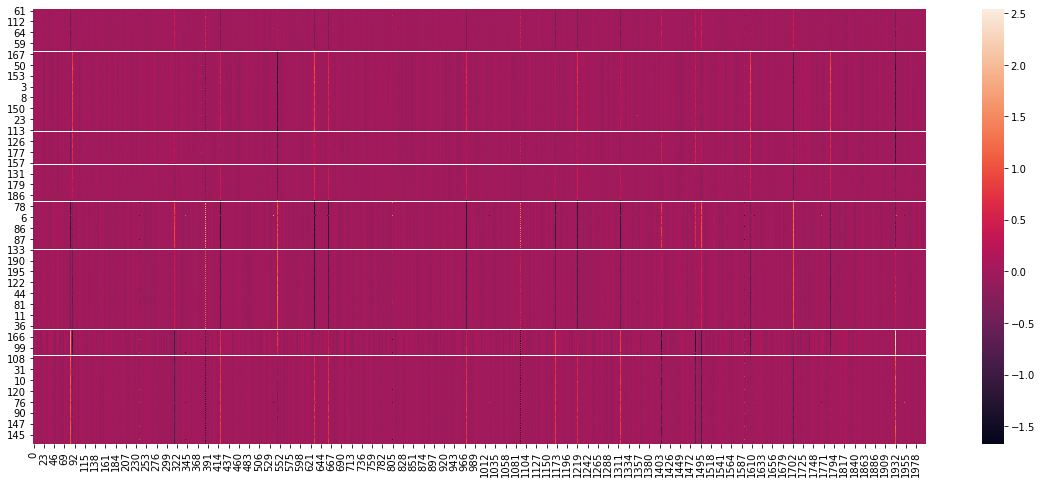

In [26]:

# set axis ticks
x_labels = [i for i in range(0, 2000, 500)]
y_labels = [i for i in range(0, 200, 50)]

# plot heatmap
fig, ax = plt.subplots(figsize = (20, 8))
sns.heatmap(data = new_eigenvectors_df.loc[:, new_eigenvectors_df.columns != "cluster_assignment"])

x_min, x_max = plt.xlim()

for counts_idx in range(len(cumulative_sum_pca)-1):
    ax.hlines(y = cumulative_sum_pca[counts_idx], xmin = x_min, xmax = x_max, color = 'white', lw = 1)
